In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split

import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal
from torch.distributions import kl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model will be trained on {device}.")
EPS = 1e-6  # for numerical stability control

The model will be trained on cpu.


## Introduction to Neural Networks

### What are Neural Networks?

Neural Networks (NNs) are a class of machine learning models inspired by the structure and function of the human brain. They consist of interconnected nodes (neurons) organized in layers, designed to recognize patterns in data and make decisions or predictions based on those patterns.

### Why Use Neural Networks?

Neural networks are quite an old method now but have found large popularity. They are quite versatile, easy to conceptualise, and show remarkable ability in a wid range of tasks from classification to dimension reduction. Neural networks have the following advantages going for them:

1. **Handling complex, non-linear relationships**: Neural networks can model intricate, non-linear relationships in data, making them suitable for a wide range of real-world problems.

2. **Automatic feature extraction**: Deep neural networks can automatically learn relevant features from raw data, reducing the need for manual feature engineering.

3. **Scalability**: Neural networks can handle large amounts of data and scale well with increasing data sizes and computational resources. 

4. **Versatility**: They can be applied to various tasks such as classification, regression, clustering, and dimensionality reduction.

5. **Continuous learning**: Neural networks can be updated with new data, allowing them to adapt to changing environments.

### Applications of Neural Networks

Neural networks have found applications in numerous fields, including:

- **Computer Vision**: Image classification, object detection, facial recognition
- **Game Playing**: Developing AI that can play complex games like Go
- **Autonomous Vehicles**: Processing sensor data for navigation and decision making

### Basic Structure of a Neural Network

A typical neural network consists of:

1. **Input Layer**: Receives the initial data
2. **Hidden Layers**: Process the data through weighted connections
3. **Output Layer**: Produces the final prediction or decision

Each neuron in these layers applies an activation function to its inputs, introducing non-linearity into the model. We will now look at a simple example usage of neural networks for the problem of classification. Before this however, you may want to check out the following online resource for an interactive demonstration of a neural network:

https://playground.tensorflow.org/

### The Moons Dataset

The "moons" dataset is a popular toy dataset, often used for binary classification tasks. It's called the moons dataset because it creates two interleaving half circles when plotted, resembling two crescent moons.

Key characteristics of the moons dataset:

1. It's a 2D dataset, meaning each sample has two features (x & y coordinates).
2. It has two classes, typically labeled as 0 and 1 representing which of the two moons a point belongs to.
3. The classes are not linearly separable, making it a good test for the non-linear capabilities of neural networks.
4. We can control the amount of noise added to the data, which affects how cleanly the two classes can be separated.

This dataset is particularly useful for visualizing the decision boundary of a classifier, as we can easily plot the data and the model's predictions in a 2D space.

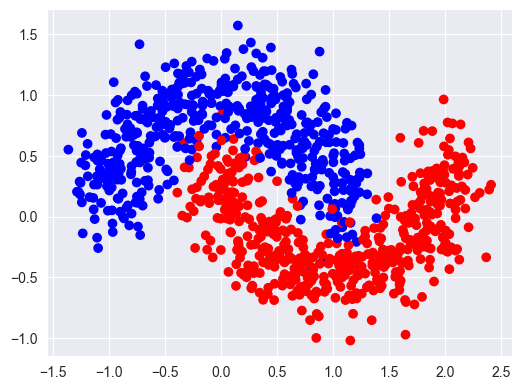

In [15]:
# Generate the moons dataset
X, Y = datasets.make_moons(1000, noise=0.20, random_state=6)

# Plot the dataset
plt.figure(figsize=(6, 4.5))
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="bwr")
sns.despine()
plt.show()

We can see above the two classes (blue and red), and each sample point that forms our two moons. We can also see the non-linear boundary as well as some overlap between the classes.

#### Test & Training Split

We define the test size to be 25% of the total data set and use the 75% remaining for training. This should 

In [16]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=45)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.get_default_dtype())
X_test = torch.tensor(X_test, dtype=torch.get_default_dtype())
y_train = torch.tensor(y_train, dtype=torch.get_default_dtype()).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.get_default_dtype()).view(-1, 1)

# Set the meshgrid
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#### Constructing a NN

Now we create the conventional NN using PyTorch- a very common library for machine learning in Python. We start with 2 inputs, go through a series of layers, and output a single value. 

In [17]:
class ConventionalNN(nn.Module):
    def __init__(self, features):
        super(ConventionalNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(nn.Linear(features[i], features[i+1]))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return self.sigmoid(X)

    def loss_fn(self, X, y, reg_lambda=0., reg_ord=2):
        y_pred = self.forward(X)
        loss = F.binary_cross_entropy(y_pred, y)
        if reg_lambda == 0.:
            return loss
        else:  # We can add a regularizer here to penalize large weights.
            reg_term = sum(torch.linalg.vector_norm(param, ord=reg_ord) ** reg_ord for param in self.parameters())
            return loss + reg_lambda / y.shape[0] * reg_term

    @torch.no_grad()
    def predict(self, X_test, y_test=None, batch_size=None, device=torch.device('cpu')):
        test_dataset = TensorDataset(X_test, y_test) if y_test is not None else TensorDataset(X_test)
        batch_size = len(test_dataset) if batch_size is None else batch_size
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        self.to(device)
        if y_test is not None:
            wrong = 0
            for x, y in test_dataloader:
                x, y = x.to(device), y.to(device)
                y_pred = self.forward(x)
                y_pred = (y_pred >= 0.5).to(torch.get_default_dtype())
                wrong += (y_pred - y).abs().sum().item()
            return 1 - wrong / len(test_dataset)
        else:
            preds = []
            for x in test_dataloader:
                y_pred = self.forward(x[0].to(device))
                preds.append(y_pred)
            return torch.cat(preds, dim=-2).to(torch.device('cpu'))

# construct NN
features = [2, 8, 16, 16, 8, 1]

mlp = ConventionalNN(features)

### Training our NN

Training is the heart of the machine learning process. It's where our neural network learns to make accurate predictions by adjusting its internal parameters (weights and biases) based on the input data. The training process involves several key concepts:

1. **Batching**: We divide our data into small batches to process at a time. This improves efficiency and helps the model generalize better.

2. **Forward Pass**: The input data is passed through the network, generating predictions.

3. **Loss Calculation**: We compare the model's predictions to the true labels using a loss function, which quantifies how far off our predictions are.

4. **Backpropagation**: The error is propagated backwards through the network, calculating how each parameter contributed to the error.

5. **Optimization**: An optimization algorithm (in this case, Adam) updates the model's parameters to minimize the loss.

6. **Epochs**: We repeat this process multiple times over the entire dataset, with each full pass called an epoch.

The `train` function encapsulates this entire process. It takes our model, data, and various hyperparameters as inputs, then iteratively improves the model's performance. By the end of training, our neural network should be able to accurately classify the moon dataset.

Epoch [50/1000], Loss: 0.0590
Epoch [100/1000], Loss: 0.0622
Epoch [150/1000], Loss: 0.0781
Epoch [200/1000], Loss: 0.0468
Epoch [250/1000], Loss: 0.0523
Epoch [300/1000], Loss: 0.0299
Epoch [350/1000], Loss: 0.0419
Epoch [400/1000], Loss: 0.0741
Epoch [450/1000], Loss: 0.0519
Epoch [500/1000], Loss: 0.0401
Epoch [550/1000], Loss: 0.0550
Epoch [600/1000], Loss: 0.0522
Epoch [650/1000], Loss: 0.0660
Epoch [700/1000], Loss: 0.0553
Epoch [750/1000], Loss: 0.0506
Epoch [800/1000], Loss: 0.0291
Epoch [850/1000], Loss: 0.0588
Epoch [900/1000], Loss: 0.0474
Epoch [950/1000], Loss: 0.0584
Epoch [1000/1000], Loss: 0.0418


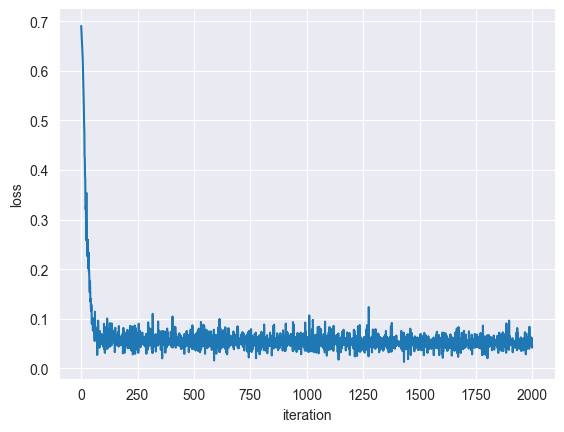

In [18]:
def train(
        model, X, y, batch_size=32, lr=0.01, reg_lambda=0., reg_ord=2,
        epochs=10, print_iters=50, device=torch.device('cpu')
):
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # DataLoader for batching
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()  # Set model to training mode
    model.to(device)

    losses = []
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()                 # Zero the gradient
            loss = model.loss_fn(
                inputs, labels, reg_lambda, reg_ord
            )                                     # Loss function (CrossEntropyLoss in this case)
            loss.backward()                       # Backpropagation
            optimizer.step()                      # Update weights
            losses.append(loss.item())

        if (epoch + 1) % print_iters == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model, losses

mlp, loss_list = train(mlp, X_train, y_train, batch_size=500, lr=0.01, epochs=1000, device=device)

plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
sns.despine()

We see above how our model improves through iterations via a decreased loss value. 

### Model Performance

We need ways to compare our models performance to other models (or potentially to different parameters in our model). A very simple measure is accuracy as shown below:

In [19]:
mlp.eval()
acc = mlp.predict(X_test, y_test, device=device)

print(f"The accuracy on the test data is {acc * 100:.2f}%")

The accuracy on the test data is 95.60%


However, we've essentially just compressed all of our model and its learning into a single value. Sometimes to properly compare models and their predictions we want a bit more information than just accuracy. For this, we could consider decision boundaries.

A decision boundary is the region of a problem space where a machine learning model switches from predicting one class to another. In other words, it's the line that separates different classes in the feature space.

Key points about decision boundaries:

1. **Shape**: For linear models, the decision boundary is always a straight line. For non-linear models like neural networks, decision boundaries can be curved and complex.

2. **Interpretation**: Points on one side of the boundary are classified as one class, while points on the other side are classified as the other class.

3. **Model Complexity**: The complexity of the decision boundary often reflects the complexity of the model. Simple models produce simple boundaries, while more complex models can create more intricate boundaries capturing more complex relationships.

4. **Overfitting**: Very complex decision boundaries that closely fit the training data might indicate overfitting, where the model learns the noise in the training data too well and may not generalize to new data.

5. **Visualization**: For 2D datasets like our moons dataset, we can visualize the decision boundary by creating a grid of points, having our model predict the class for each point, and then plotting these predictions.

Below we show how to plot a decision boundary for our binary classification on the two moons dataset using our implemented NN.

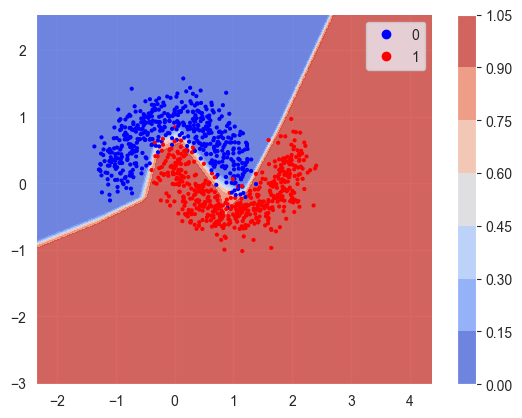

In [20]:
def plot_binary_class(X_scatters, y_scatters, xx1_grid, xx2_grid, grid_preds_mean, legend=False, color_bar=False):
    """
    Function to plot binary classification outputs.
    """
    fig, ax = plt.subplots(1, 1)

    CS = ax.contourf(xx1_grid, xx2_grid, grid_preds_mean, cmap="coolwarm", alpha=0.8)
    hs = ax.scatter(X_scatters[:, 0], X_scatters[:, 1], c=y_scatters, s=4, cmap="bwr")

    if legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_actual, labels_actual = hs.legend_elements()
        handles_actual.extend(handles)
        labels_actual.extend(labels)
        ax.legend(handles_actual, labels_actual)

    if color_bar:
        fig.colorbar(CS)

    sns.despine()


# Predict on grid
inputs = np.stack([xx.ravel(), yy.ravel()], axis=-1)
p = mlp.predict(torch.as_tensor(inputs, dtype=torch.get_default_dtype()), device=device)
p = p.reshape(xx.shape)

plot_binary_class(X, Y, xx, yy, p, legend=True, color_bar=True)

### Exercise: Exploring Neural Network Structures

In this exercise, we'll explore how changes in the neural network structure and training process affect its performance and decision boundaries. This will help you understand the impact of various hyperparameters and architectural choices.

#### 1. Changing the Hidden Layers

Start by modifying the number of hidden layers and the number of nodes in these layers. What happens if you make the NN really wide but shallow and vice versa? What if you have a really deep amount of layers? See which ways seem to improve the accuracy and the decision boundaries. Take our previous code and adapt it here to define a new NN model.

In [21]:
#Your code here. 

#### 2. Change the Activation Functions

We just use ReLu previously. What if we use different activation functions like ELU, TanH, or leakyRELU?

In [22]:
#Code here

#### 3. Regularisation

We can use an L2 regulariser in our training. Can you find out how to add this L2 regulariser to our NN model and see what effect it has on accuracy, the loss graph, and the decision boundary?

In [23]:
#Code here

### Models on Limited Data

What if we were in a situation where we did not have that much training data? How would our conventional NN perform? You should experiment with different ratios of training/testing data below to see how it impacts the decision boundaries and accuracy of our model.

In [24]:
#Add your code to see how the decision boundary and accuracy changes as the training data size changes

# Split the dataset into training and testing sets
X_smalltrain, X_bigtest, y_smalltrain, y_bigtest = train_test_split(X, Y, test_size=0.75, random_state=45)

# Convert the data to PyTorch tensors
X_smalltrain = torch.tensor(X_smalltrain, dtype=torch.get_default_dtype())
X_bigtest = torch.tensor(X_bigtest, dtype=torch.get_default_dtype())
y_smalltrain = torch.tensor(y_smalltrain, dtype=torch.get_default_dtype()).view(-1, 1)
y_bigtest = torch.tensor(y_bigtest, dtype=torch.get_default_dtype()).view(-1, 1)

# Set the meshgrid
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


## YOUR CODE BELOW HERE

### Uncertainty of a NN

How can we actually get the uncertainty values for our NN? 

It is a good question- we want to know how confident we can be in our predictions. However, traditional neural networks provide point estimates without indicating how certain they are about their predictions. In many real-world applications, such as medical statistics, understanding the uncertainty of predictions is crucial.
 
We can use methods like MC Dropout to estimate Bayesian inference for uncertainty quantification.

### Monte Carlo (MC) Dropout 

MC Dropout is a simple yet effective method to estimate model uncertainty. It involves:

1. Using dropout during both training and inference.
2. Running multiple forward passes with dropout at test time.
3. Using the mean of these passes as the prediction and the variance as a measure of uncertainty.

Here's how we can implement MC Dropout:

Epoch [50/1000], Loss: 0.1517
Epoch [100/1000], Loss: 0.0810
Epoch [150/1000], Loss: 0.0800
Epoch [200/1000], Loss: 0.0698
Epoch [250/1000], Loss: 0.0751
Epoch [300/1000], Loss: 0.0692
Epoch [350/1000], Loss: 0.0857
Epoch [400/1000], Loss: 0.0904
Epoch [450/1000], Loss: 0.0518
Epoch [500/1000], Loss: 0.0579
Epoch [550/1000], Loss: 0.0723
Epoch [600/1000], Loss: 0.1146
Epoch [650/1000], Loss: 0.0876
Epoch [700/1000], Loss: 0.0692
Epoch [750/1000], Loss: 0.0873
Epoch [800/1000], Loss: 0.1004
Epoch [850/1000], Loss: 0.0386
Epoch [900/1000], Loss: 0.0492
Epoch [950/1000], Loss: 0.1013
Epoch [1000/1000], Loss: 0.0752
The accuracy on the test data is 96.80%


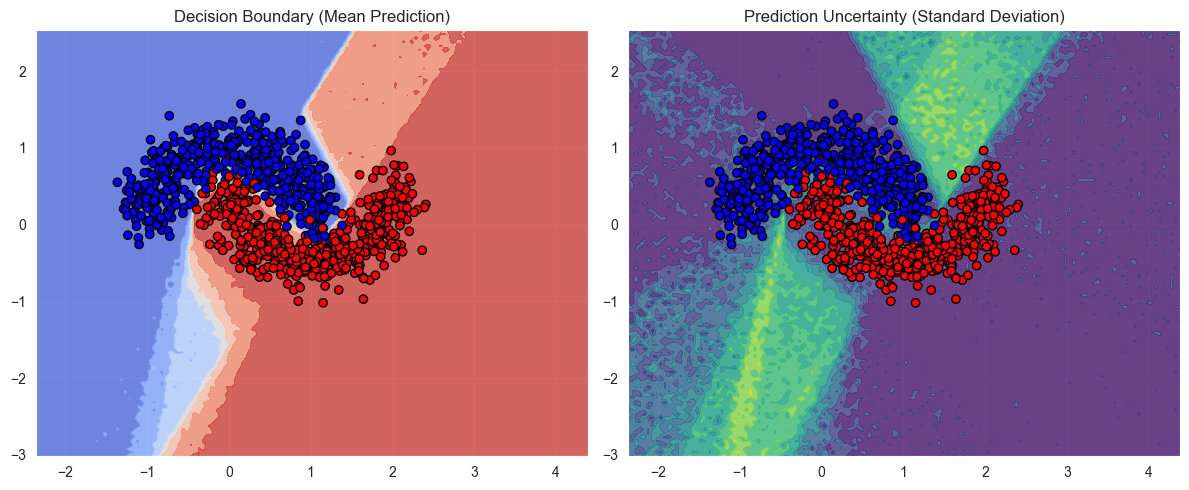

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

class MCDropoutNN(nn.Module):
    def __init__(self, features, dropout_rate=0.1):
        super(MCDropoutNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(nn.Linear(features[i], features[i+1]))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(p=dropout_rate))
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return self.sigmoid(X)

    def loss_fn(self, X, y):
        y_pred = self.forward(X)
        return F.binary_cross_entropy(y_pred, y)

    @torch.no_grad()
    def predict(self, X_test, y_test=None, num_samples=100, batch_size=None, device=torch.device('cpu')):
        test_dataset = TensorDataset(X_test, y_test) if y_test is not None else TensorDataset(X_test)
        batch_size = len(test_dataset) if batch_size is None else batch_size
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        self.to(device)
        self.train()  # Set to train mode to enable dropout

        if y_test is not None:
            all_preds = []
            for _ in range(num_samples):
                preds = []
                for x, y in test_dataloader:
                    x, y = x.to(device), y.to(device)
                    y_pred = self.forward(x)
                    preds.append(y_pred)
                preds = torch.cat(preds, dim=0)
                all_preds.append(preds)
            
            all_preds = torch.stack(all_preds)
            mean_preds = all_preds.mean(dim=0)
            y_pred = (mean_preds >= 0.5).float()
            
            wrong = (y_pred - y_test.to(device)).abs().sum().item()
            return 1 - wrong / len(test_dataset)
        else:
            all_preds = []
            for _ in range(num_samples):
                preds = []
                for x in test_dataloader:
                    x = x[0].to(device)
                    y_pred = self.forward(x)
                    preds.append(y_pred)
                preds = torch.cat(preds, dim=0)
                all_preds.append(preds)
            
            all_preds = torch.stack(all_preds)
            mean_preds = all_preds.mean(dim=0)
            std_preds = all_preds.std(dim=0)
            return mean_preds.cpu(), std_preds.cpu()

def train(model, X, y, batch_size=32, lr=0.01, epochs=10, print_iters=50, device=torch.device('cpu')):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    model.to(device)

    losses = []
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = model.loss_fn(inputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if (epoch + 1) % print_iters == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model, losses

# Usage example
features = [2, 8, 16, 16, 8, 1]
mc_dropout_nn = MCDropoutNN(features, dropout_rate=0.1)

# Train the model
mc_dropout_nn, loss_list = train(mc_dropout_nn, X_train, y_train, batch_size=500, lr=0.01, epochs=1000, device=device)

# Evaluate on test data
accuracy = mc_dropout_nn.predict(X_test, y_test, num_samples=100, device=device)
print(f"The accuracy on the test data is {accuracy * 100:.2f}%")

# Predict on grid with uncertainty
inputs = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)
mean_preds, std_preds = mc_dropout_nn.predict(inputs, num_samples=100, device=device)
mean_preds = mean_preds.reshape(xx.shape)
std_preds = std_preds.reshape(xx.shape)

# Plot decision boundary with uncertainty
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.contourf(xx, yy, mean_preds, cmap='coolwarm', alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='bwr', edgecolors='black')
plt.title('Decision Boundary (Mean Prediction)')

plt.subplot(122)
plt.contourf(xx, yy, std_preds, cmap='viridis', alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='bwr', edgecolors='black')
plt.title('Prediction Uncertainty (Standard Deviation)')

plt.tight_layout()
plt.show()

#### Impacts on Uncertainty

Which of our previous modelling decisions have an impact on our uncertainty estimation? 

Try the following:

1. Change the dropout rate
2. Change the training data size
3. Change number of epochs

In [26]:
#Your code here

# Bayesian Neural Networks

## What are Bayesian Neural Networks?

Unlike traditional neural networks, which provide point estimates of their parameters (weights and biases), BNNs treat these parameters as probability distributions. This Bayesian approach allows for a principled way of understanding model uncertainty, which is crucial in many real-world applications where the reliability of a model's predictions is as important as the predictions themselves.

## Key Concepts

To understand BNNs, it's essential to grasp a few key concepts:

1. **Probability Distributions over Weights**: In a BNN, each weight is represented not by a single value, but by a probability distribution (often a Gaussian distribution). This distribution captures our uncertainty about the "true" value of the weight.

2. **Prior Distributions**: Before seeing any data, we specify our initial beliefs about the weights through prior distributions. These priors encode our assumptions about the model parameters.

3. **Posterior Distributions**: After observing data, we update our beliefs about the weights. The resulting distributions are called posterior distributions, representing our updated knowledge about the model parameters.

4. **Bayesian Inference**: The process of updating our beliefs (moving from prior to posterior) is done through Bayesian inference, typically using Bayes' theorem.

5. **Prediction Uncertainty**: When making predictions with a BNN, we can propagate the uncertainty in the weights to get a distribution over possible outputs, rather than a single point estimate.

## Advantages of Bayesian Neural Networks

BNNs offer several advantages over traditional neural networks:

1. **Uncertainty Quantification**: BNNs provide a principled way to estimate the uncertainty in predictions, which is crucial in decision-making processes.

2. **Regularization**: The Bayesian approach naturally guards against overfitting by integrating over all possible parameter values.

3. **Robustness to Overfitting**: BNNs are less prone to overfitting, especially when dealing with small datasets.

4. **Handling Small Data**: BNNs can perform well even with limited data, as they can incorporate prior knowledge and quantify uncertainty.

5. **Model Comparison**: Bayesian methods provide natural ways to compare different models through techniques like Bayesian model averaging.

## Challenges in Bayesian Neural Networks

Despite their advantages, BNNs come with their own set of challenges:

1. **Computational Complexity**: Exact Bayesian inference is often intractable for neural networks, necessitating the use of approximation techniques.

2. **Scalability**: Many Bayesian inference techniques struggle with large datasets and complex network architectures.

3. **Choice of Priors**: Selecting appropriate prior distributions can be challenging and can significantly impact the model's performance.

4. **Interpretation**: Understanding and interpreting the full posterior distribution over weights can be more complex than interpreting point estimates.


### Construct a Bayesian linear layer

We start with defining our Bayesian linear layer - a necessary step and one we did not have to do for our traditional NN.


In [27]:
class BayesianLinear(nn.Module):
    def __init__(
            self, in_features, out_features,
            prior_weight_std=0.1, prior_bias_std=0.1, lecun_init=False
    ):
        super(BayesianLinear, self).__init__()

        # Define the prior params
        prior_mean = 0.
        if lecun_init:  # LeCun initialization：prior variance scales as 1/dim_in
            prior_weight_std /= in_features ** 0.5
            prior_bias_std /= in_features ** 0.5
        # Prior parameters registered as constants
        self.register_buffer('prior_weight_mean', torch.full([out_features, in_features], prior_mean))
        self.register_buffer('prior_weight_std', torch.full([out_features, in_features], prior_weight_std))
        self.register_buffer('prior_bias_mean', torch.full([out_features], prior_mean))
        self.register_buffer('prior_bias_std', torch.full([out_features], prior_bias_std))

    def prior_forward(self, x):
        # Sample weights and biases from prior normal distributions
        prior_weight = self.prior_weight_mean + self.prior_weight_std * torch.randn_like(self.prior_weight_std)
        prior_bias = self.prior_bias_mean + self.prior_bias_std * torch.randn_like(self.prior_bias_std)
        return F.linear(x, prior_weight, prior_bias)


### The BNN Model

With our new Bayesian linear layer, we are free to now define our BNN model. 

In [28]:
class BayesianNN(nn.Module):
    def __init__(self, features, **layer_prior_kwargs):
        super(BayesianNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(BayesianLinear(features[i], features[i+1], **layer_prior_kwargs))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
        self.sigmoid = nn.Sigmoid()

    @torch.no_grad()
    def prior_forward(self, x):
        for layer in self.layers:
            if isinstance(layer, BayesianLinear):
                x = layer.prior_forward(x)
            else:
                x = layer(x)
        return self.sigmoid(x)

### Random functions from the prior

We can now sample the prior random functions output by the BNN to see the effects of changing the prior hyperparameters. Try changing it yourself to see the impacts below!

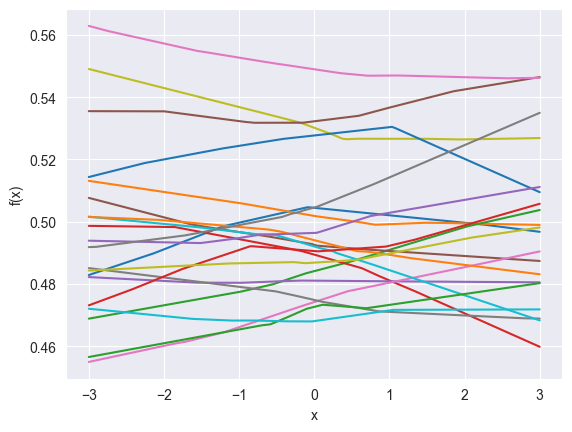

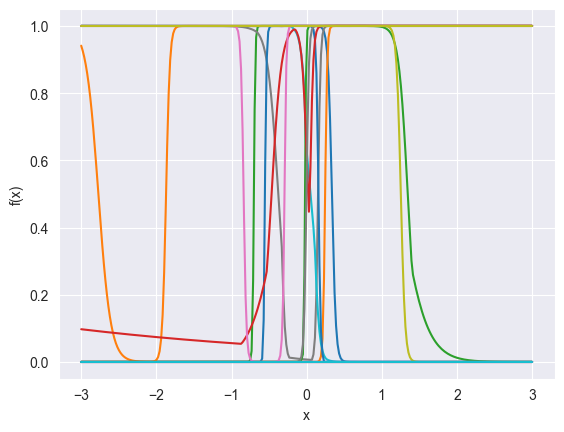

In [29]:
def sample_prior(model, num_samples, x):
    # Sample random functions
    prior_samples = []
    for _ in range(num_samples):
        sample = model.prior_forward(x)
        prior_samples.append(sample)

    # Plot samples
    for i in range(num_samples):
        plt.plot(x.numpy().reshape([-1]), prior_samples[i].numpy().reshape([-1]))

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.show()


# Construct a 2-layer BNN
features = [1, 10, 1]
BNN = BayesianNN(features)

# Plot
num_samples = 20
x = torch.linspace(-3, 3, 300).view(-1, 1)
sample_prior(BNN, num_samples, x)

# We can change the prior to see its effect on the output functions
BNN = BayesianNN(features, prior_weight_std=10., prior_bias_std=5., lecun_init=True)
sample_prior(BNN, num_samples, x)

## Inference - Posterior Approximation

Exact Bayesian inference is typically intractable for neural networks due to the high dimensionality of the parameter space. We can use something called 'mean-field variational inference' (MFVI, also known as [Bayes-by-backprop](https://arxiv.org/abs/1505.05424)) to approximate the posterior distributions of the BNN parameters.

### Mean-field Variational Inference (MFVI)

## The Basics of Variational Inference

Variational inference, in general, aims to approximate a complex posterior distribution P(w|D) with a simpler distribution Q(w|θ), where w represents the model parameters (weights in a neural network), D is the observed data, and θ are the parameters of the approximating distribution.

The goal is to minimize the Kullback-Leibler (KL) divergence between the approximate posterior Q(w|θ) and the true posterior P(w|D):

KL[Q(w|θ) || P(w|D)]

This is equivalent to maximizing the Evidence Lower Bound (ELBO):

ELBO = E[log P(D|w)] - KL[Q(w|θ) || P(w)]

Where P(w) is the prior distribution over the weights.

## Mean-Field Approximation

The "mean-field" part of MFVI comes from the assumption that the approximating distribution Q can be factorized into independent distributions over each parameter:

Q(w|θ) = ∏ Q(w_i|θ_i)

This assumption significantly simplifies the optimization problem and makes the inference computationally tractable, especially for high-dimensional problems like neural networks.

## Application to Bayesian Neural Networks

In the context of Bayesian Neural Networks, as described in the paper "Weight Uncertainty in Neural Networks" by Blundell et al., MFVI is used as follows:

1. **Variational Posterior**: Each weight in the network is assigned a probability distribution (typically Gaussian) instead of a point estimate. The parameters of these distributions (mean and variance) become the learnable parameters of the network.

2. **Prior**: A prior distribution is placed over the weights. The paper uses a scale mixture of two Gaussian distributions as the prior, which allows for both sparsity and regularization.

3. **Objective Function**: The training objective becomes the variational free energy, which is equivalent to the negative ELBO:

   F(D, θ) = KL[Q(w|θ) || P(w)] - E[log P(D|w)]

   This objective balances between fitting the data (the likelihood term) and keeping the approximate posterior close to the prior (the KL divergence term).

4. **Optimization**: The objective is optimized using gradient descent. The gradients are estimated using the "reparameterization trick", which allows backpropagation through the random sampling process.

5. **Inference**: During inference, weight samples are drawn from the learned posterior distributions, effectively creating an ensemble of networks. This allows for uncertainty estimation in the predictions.

We show the implementation of MFVI to our BNN below:

In [30]:
class MFVIBayesianLinear(BayesianLinear):  # inherit
    def __init__(
            self, in_features, out_features,
            init_std=0.1, **layer_prior_kwargs
    ):
        super(MFVIBayesianLinear, self).__init__(in_features, out_features, **layer_prior_kwargs)

        # Mean and log variance for weights and biases of variational distributions
        self.weight_mean = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_logstd = nn.Parameter(torch.ones(out_features, in_features))
        self.bias_mean = nn.Parameter(torch.zeros(out_features))
        self.bias_logstd = nn.Parameter(torch.ones(out_features))

        # initialization
        self.reset_params(in_features, init_std)

    def reset_params(self, in_features, init_std):
        # initialization
        nn.init.kaiming_uniform_(self.weight_mean)
        bound = 1 / in_features ** 0.5
        nn.init.uniform_(self.bias_mean, -bound, bound)
        nn.init.constant_(self.weight_logstd, math.log(init_std + EPS))
        nn.init.constant_(self.bias_logstd, math.log(init_std + EPS))

    @property
    def weight_std(self):
        return torch.exp(self.weight_logstd)

    @property
    def bias_std(self):
        return torch.exp(self.bias_logstd)

    def forward(self, x, sample_shape=torch.Size([])):  # Sample weights and biases from normal distributions
        # weight = self.weight_mean + self.weight_std * torch.randn_like(self.weight_std)
        # bias = self.bias_mean + self.bias_std * torch.randn_like(self.bias_std)
        # return F.linear(x, weight, bias)
        weight = Normal(self.weight_mean, self.weight_std).rsample(sample_shape)
        bias = Normal(self.bias_mean, self.bias_std).rsample(sample_shape)
        return x @ weight.mT + bias.unsqueeze(-2)

    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q_weight = Normal(self.weight_mean, self.weight_std)
        p_weight = Normal(self.prior_weight_mean, self.prior_weight_std)
        q_bias = Normal(self.bias_mean, self.bias_std)
        p_bias = Normal(self.prior_bias_mean, self.prior_bias_std)
        return kl.kl_divergence(q_weight, p_weight).sum() + kl.kl_divergence(q_bias, p_bias).sum()


In [31]:
class MFVIBayesianNN(nn.Module):
    def __init__(self, features, init_std=0.1, **layer_prior_kwargs):
        super(MFVIBayesianNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(MFVIBayesianLinear(features[i], features[i+1], init_std, **layer_prior_kwargs))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, sample_shape=torch.Size([])):
        for layer in self.layers:
            x = layer(x, sample_shape) if isinstance(layer, MFVIBayesianLinear) else layer(x)
        return self.sigmoid(x)

    def expected_log_prob(self, X, y, num_samples=1):
        y_pred = self.forward(X, torch.Size([num_samples])).mean(dim=0)
        loss = F.binary_cross_entropy(y_pred, y, reduction='mean')
        return - loss

    # collect the kl divergence for all MFVILinear layers
    def kl_divergence(self):
        kl = 0.
        for layer in self.layers:
            if isinstance(layer, MFVIBayesianLinear):
                kl = kl + layer.kl_divergence()
        return kl

    def loss_fn(self, X, y, num_data, num_samples=1, tempered=1.):
        data_fit = self.expected_log_prob(X, y, num_samples)
        kl = self.kl_divergence() * tempered / num_data
        return - (data_fit - kl)

    @torch.no_grad()
    def predict(
            self, X_test, y_test=None, num_samples=1,
            batch_size=None, device=torch.device('cpu')
    ):
        test_dataset = TensorDataset(X_test, y_test) if y_test is not None else TensorDataset(X_test)
        batch_size = len(test_dataset) if batch_size is None else batch_size
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        self.to(device)
        if y_test is not None:
            preds = []
            for x, y in test_dataloader:
                x, y = x.to(device), y.to(device)
                y_pred = self.forward(x, torch.Size([num_samples])).mean(dim=0)
                preds.append(y_pred)
            preds = torch.cat(preds, dim=-2)
            y_pred = (preds >= 0.5).to(torch.get_default_dtype())

            print(f"{y_pred.device}, {y_test.device}")

            wrong = (y_pred - y_test).abs().sum().item()
            return 1 - wrong / len(test_dataset)

        else:
            preds = []
            for x in test_dataloader:
                x = x[0].to(device)
                y_pred = self.forward(x, torch.Size([num_samples])).mean(dim=0)
                preds.append(y_pred)
            preds = torch.cat(preds, dim=-2)
            return preds.to(torch.device('cpu'))

In [32]:
# Construct a BNN with the same structure
features = [2, 8, 16, 16, 8, 1]
init_std = 0.01
layer_prior_kwargs = {
    'prior_weight_std': 1,
    'prior_bias_std': 1,
    'lecun_init': True
}
bnn = MFVIBayesianNN(features, init_std, **layer_prior_kwargs)

#### Train BNN

We now train the given BNN model using the same training regime as for our traditional neural network.

Epoch [100/1500], Loss: 0.9686
Epoch [200/1500], Loss: 0.3953
Epoch [300/1500], Loss: 0.3467
Epoch [400/1500], Loss: 0.3206
Epoch [500/1500], Loss: 0.3554
Epoch [600/1500], Loss: 0.2960
Epoch [700/1500], Loss: 0.2961
Epoch [800/1500], Loss: 0.2910
Epoch [900/1500], Loss: 0.3281
Epoch [1000/1500], Loss: 0.2992
Epoch [1100/1500], Loss: 0.3119
Epoch [1200/1500], Loss: 0.2752
Epoch [1300/1500], Loss: 0.3168
Epoch [1400/1500], Loss: 0.3099
Epoch [1500/1500], Loss: 0.3256


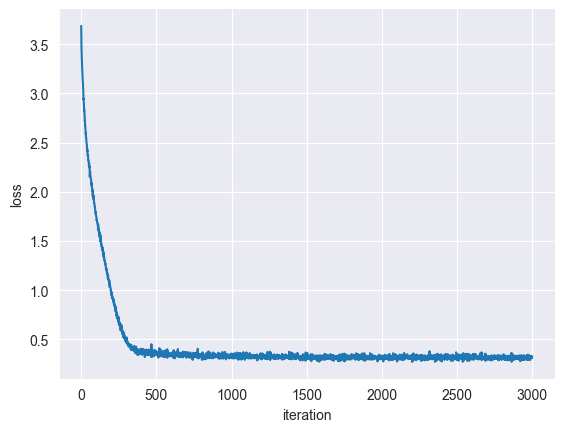

In [33]:
def train(
        model, X, y, batch_size=32, lr=0.01, num_samples=100, tempered=1.,
        epochs=10, print_iters=50, device=torch.device('cpu')
):
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # DataLoader for batching
    dataset = TensorDataset(X, y)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()  # Set model to training mode
    model.to(device)

    losses = []
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()                 # Zero the gradient
            loss = model.loss_fn(
                inputs, labels, num_data=len(dataset),
                num_samples=num_samples, tempered=tempered
            )                                     # Loss function (CrossEntropyLoss in this case)
            loss.backward()                       # Backpropagation
            optimizer.step()                      # Update weights
            losses.append(loss.item())

        if (epoch + 1) % print_iters == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model, losses

# Train the BNN
bnn, loss_list = train(bnn, X_train, y_train, batch_size=500, lr=0.01, num_samples=10, tempered=1,
                       epochs=1500, print_iters=100, device=device)

plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
sns.despine()

cpu, cpu
The accuracy on the test data is 96.40%


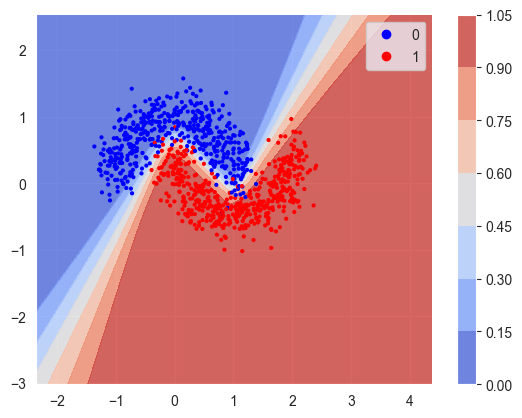

In [34]:
# Predict on test data
bnn.eval()
acc = bnn.predict(X_test, y_test, num_samples=100, device=device)

print(f"The accuracy on the test data is {acc * 100:.2f}%")

# Predict on grid
inputs = np.stack([xx.ravel(), yy.ravel()], axis=-1)
p = bnn.predict(torch.as_tensor(inputs, dtype=torch.get_default_dtype()),
                num_samples=100, device=device)
p = p.reshape(xx.shape)

plot_binary_class(X, Y, xx, yy, p, legend=True, color_bar=True)

### How does our BNN compare with our NN? 

We now want you to perform a series of comparisons between the BNN implementation and the conventional NN. Look at in particular:

1. How does the loss graph differ?
2. Can you attain the same performance as the NN using a BNN with a smaller network structure (fewer hidden layers, less nodes)?
3. What is the difference in time to run and train our models?

From these experiments, discuss and conclude what situations you might find yourself wanting to use a BNN over a NN. 

In [ ]:
#Your code here!

### Last-layer BNN with full-rank Gaussian approximation

#### Hamiltoninian MC BNN


## Bayesian CNN - more complex structure